# Ignore this

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict

class PlotHelper():
    def __init__(self):
        self.reset()

    def reset(self):
        self._f = None
        self._ax = None
        self.kvals = defaultdict(list)

    def add(self, **kval):
        for k, v in kval.items():
            self.kvals[k].append(v)

    @property
    def fig(self):
        if self._f is None:
            self.new()
        return self._f

    @property
    def ax(self):
        if self._ax is None:
            self.new()
        return self._ax

    def new(self):
        self._f, self._ax = plt.subplots(1,1)
        plt.ion()
        self.fig.show()

    def show(self):
        names = []
        self.ax.clear()
        for k, v in self.kvals.items():
            names.append(k)
            self.ax.plot(v)
        self.ax.legend(names)
        self.fig.canvas.draw()

Matplotlib is building the font cache; this may take a moment.


# Basic Example

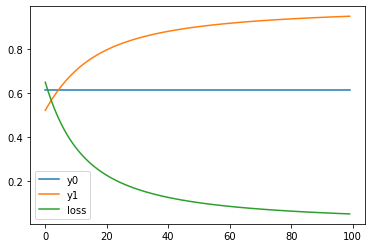

In [10]:
import torch
import torch.nn.functional as F

net = Net()

opt = torch.optim.SGD(net.parameters(), lr=0.1)

plot = PlotHelper()

x = torch.tensor([1.])
y = torch.tensor([0, 1])

for _ in range(100):
    opt.zero_grad()
    y_logit = net(x)
    loss = F.cross_entropy(y_logit[1:], y[1:])
    loss.backward()
    y_prob = torch.softmax(y_logit, dim=-1)
    plot.add(y0=y_prob[0,1].data, y1=y_prob[1,1].data, loss=loss.data)
    opt.step()

plot.show()


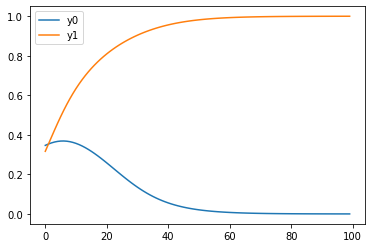

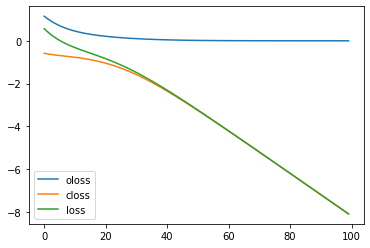

In [15]:
import torch
import itertools

from pytorch_constraints.constraint import constraint
from pytorch_constraints.brute_force_solver import *
from pytorch_constraints.sampling_solver import *

net = Net()
opt = torch.optim.SGD(net.parameters(), lr=0.1)
plot = PlotHelper()
plot_loss = PlotHelper()
x = torch.tensor([1.])
y = torch.tensor([0, 1])

def xor(y):
    return (y[0] and not y[1]) or (not y[0] and y[1])

xor_cons = constraint(xor)
# num_samples = 100
# xor_cons = constraint(xor, SamplingSolver(num_samples))

for _ in range(100):
    opt.zero_grad()
    y_logit = net(x)
    oloss = F.cross_entropy(y_logit[1:], y[1:])
    closs = xor_cons(y_logit)
    loss = oloss + closs
    loss.backward()
    y_prob = torch.softmax(y_logit, dim=-1)
    plot.add(y0=y_prob[0,1].data, y1=y_prob[1,1].data)
    plot_loss.add(oloss=oloss.data, closs=closs.data, loss=loss.data)
    opt.step()

plot.show()
plot_loss.show()